In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.express as px

In [132]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        #self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        #self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        #x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [133]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [134]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [135]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cpu


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [149]:
### Training function
loss_fn = torch.nn.BCELoss(reduction='sum')

def train_epoch(vae, optimizer, x):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    x_hat = vae(x)
    # Evaluate loss
    loss = loss_fn(x_hat, x) +  + vae.encoder.kl

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print batch loss
    print('\t partial train loss (single batch): %f' % (loss.item()))
    train_loss+=loss.item()

    return train_loss
    

In [150]:
### Testing function
def test_epoch(vae, x):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        # Move tensor to the proper device
        x = x.to(device)
        # Encode data
        encoded_data = vae.encoder(x)
        # Decode data
        x_hat = vae(x)
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl
        val_loss += loss.item()

    return val_loss

In [152]:
from stacked_mnist import StackedMNISTData, DataMode
generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)

HELLO?
(60000, 1, 28, 28)


In [153]:
num_epochs = 5000
for epoch in range(num_epochs):
   img_train, labels_train = generator.get_random_batch(training=True)
   img_test, labels_test = generator.get_random_batch(training=False)
   img_train = torch.tensor(img_train)
   img_train = img_train.type(torch.FloatTensor)
   img_test = torch.tensor(img_test)
   img_test = img_test.type(torch.FloatTensor)

   train_loss = train_epoch(vae, optim, img_train)
   val_loss = test_epoch(vae, img_test)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   #plot_ae_outputs(vae.encoder,vae.decoder,n=5)

	 partial train loss (single batch): 51940.070312

 EPOCH 1/5000 	 train loss 51940.070 	 val loss 17614.621
	 partial train loss (single batch): 53390.437500

 EPOCH 2/5000 	 train loss 53390.438 	 val loss 17448.129
	 partial train loss (single batch): 52081.898438

 EPOCH 3/5000 	 train loss 52081.898 	 val loss 18095.092
	 partial train loss (single batch): 53339.097656

 EPOCH 4/5000 	 train loss 53339.098 	 val loss 17441.730
	 partial train loss (single batch): 54218.019531

 EPOCH 5/5000 	 train loss 54218.020 	 val loss 17635.961
	 partial train loss (single batch): 52576.378906

 EPOCH 6/5000 	 train loss 52576.379 	 val loss 17050.545
	 partial train loss (single batch): 52617.191406

 EPOCH 7/5000 	 train loss 52617.191 	 val loss 17545.816
	 partial train loss (single batch): 53577.332031

 EPOCH 8/5000 	 train loss 53577.332 	 val loss 17767.432
	 partial train loss (single batch): 52600.968750

 EPOCH 9/5000 	 train loss 52600.969 	 val loss 17924.762
	 partial train los

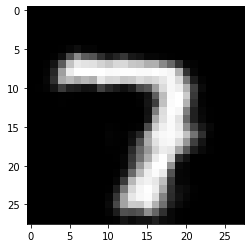

In [193]:
z = torch.Tensor(np.random.standard_normal((1, 4)))
x = vae.decoder(z)
img = x[0].detach().numpy()
img = img.reshape((28, 28))
plt.imshow(img, cmap='gist_gray')

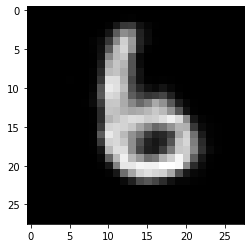

In [217]:
batch, _ = generator.get_random_batch()
batch = torch.tensor(batch)
batch = batch.type(torch.FloatTensor)
reconstructed = vae(batch)
img = reconstructed[0].detach().numpy()
img = img.reshape((28, 28))
plt.imshow(img, cmap='gist_gray')

In [237]:
from verification_net import VerificationNet
net = VerificationNet(force_learn=False, file_name="../models/verification_model")
img, labels = generator.get_random_batch(training=False, batch_size=1000)
x = torch.Tensor(img)
x = x.type(torch.FloatTensor)

with torch.no_grad():
    auto_encoded_imgs = vae(x).numpy()
auto_encoded_imgs[auto_encoded_imgs >= 0.5] = 1.0
auto_encoded_imgs[auto_encoded_imgs < 0.5] = 0.0
auto_encoded_imgs = auto_encoded_imgs.astype(np.int)
auto_encoded_imgs = auto_encoded_imgs.swapaxes(1, 2)
auto_encoded_imgs = auto_encoded_imgs.swapaxes(2, 3)
img = img.swapaxes(1, 2)
img = img.swapaxes(2, 3)

_, acc_ae = net.check_predictability(data=auto_encoded_imgs, correct_labels=labels)
print(f"Accuracy AE: {100 * acc_ae:.2f}%")
_, acc_orig = net.check_predictability(data=img, correct_labels=labels)
print(f"Accuracy Original: {100 * acc_orig:.2f}%")

Accuracy AE: 85.60%
Accuracy Original: 95.80%
